In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Bayesian General Linear Models

Bayes Theorem and Bayesian inference is used to determine posterior probability distributions. 

Here, Bayesian Inference is applied to a General Linear Model (GLM) for regression. 

### The Model
The objective is to *develop a model to predict student grades* given several input factors for student demographics. The publicly avaliable [UCI dataset](https://archive.ics.uci.edu/ml/datasets/student+performance#) contains grades and factors for 649 students taking a Portugese language course. 

In [2]:
os.listdir('./data')
raw = pd.read_csv('./data/student-por.csv',sep=';')

**Dependent variable or "Target"**
- "G3" is the students final grade for portugese (numeric: from 0 to 20, output target)

***Independent variables or "Features"***

A subset of numeric and categorical features is used to build the initial model:
- "age" student age from 15 to 22
- "internet"  student has internet access at home (binary: yes or no)
- "failures" is the number of past class failures (cat: n if 1<=n<3, else 4) 
- "higher" wants to take higher education (binary: yes or no) 
- "Medu" mother's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  ""Fedu father's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  "studytime" weekly study time (cat: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- "absences" number of school absences (numeric: from 0 to 93) 

In [3]:
# prep Xy data
df = raw.loc[~raw['G3'].isin([0])].copy()
print(df.shape)

# prep features
categoricals = ['internet','failures','higher','Medu','Fedu','studytime']
reals = ['age','absences',]
features = categoricals+reals
target = ['G3']
df = df[features+target].copy()
df[:1]

(634, 33)


,internet,failures,higher,Medu,Fedu,studytime,age,absences,G3
0,no,0,yes,4,4,2,18,4,11


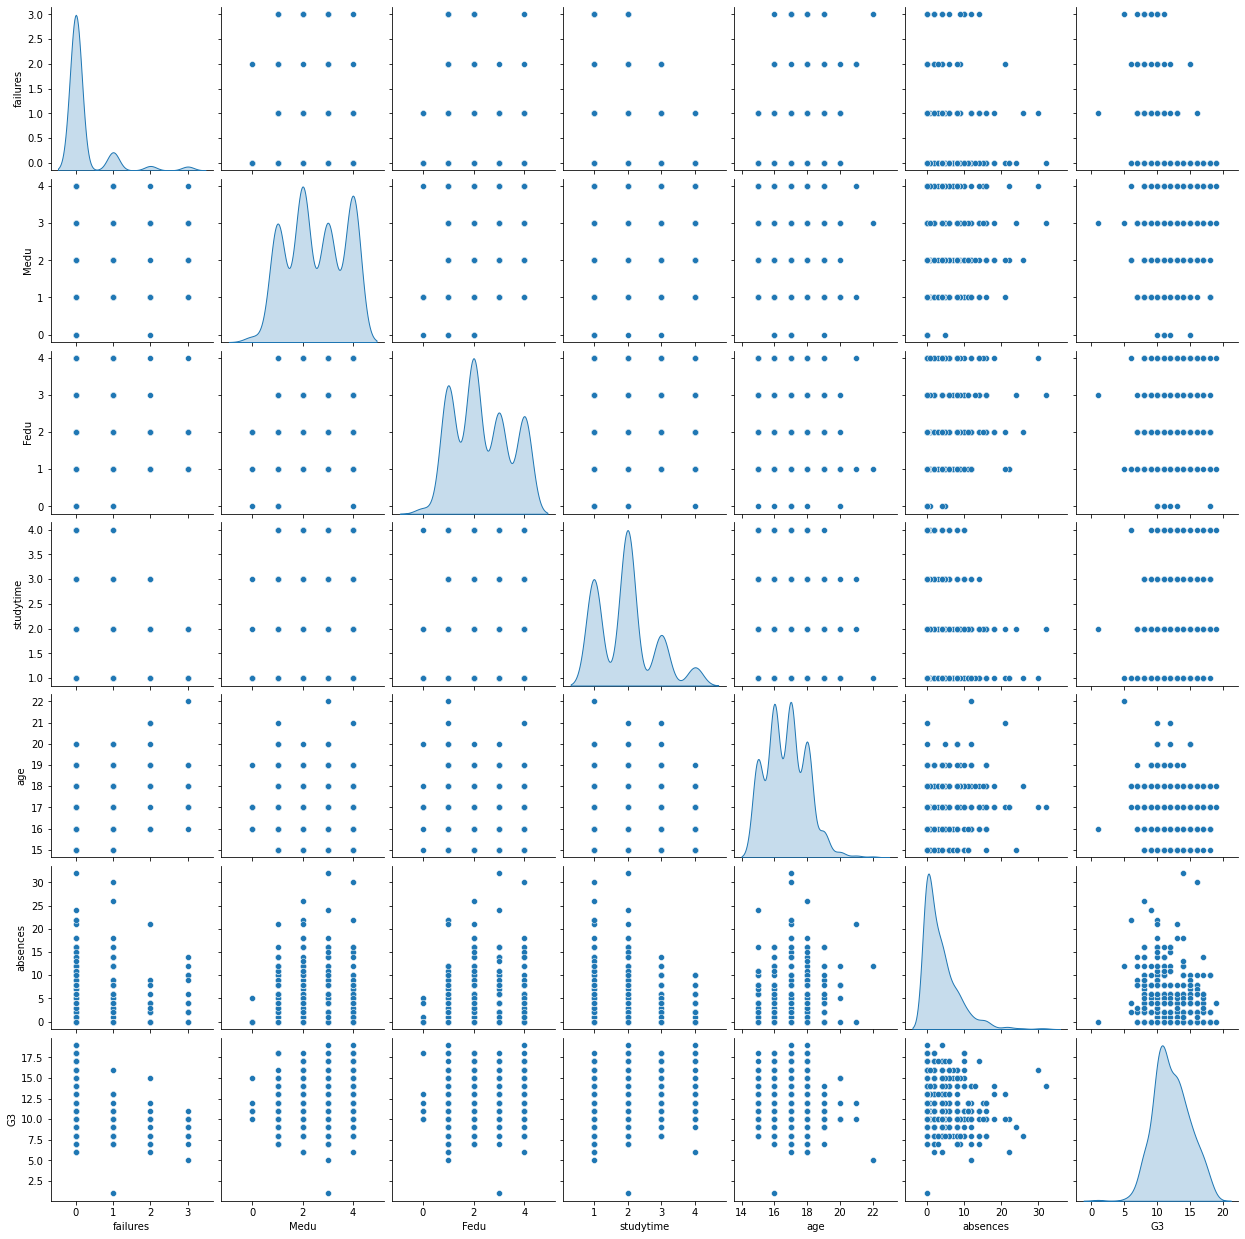

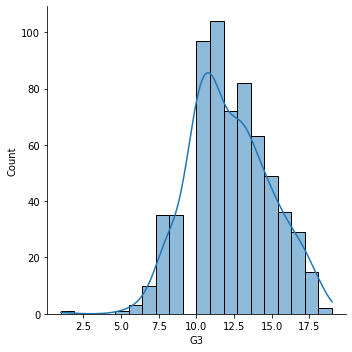

In [4]:
sns.pairplot(data=df,diag_kind='kde')
sns.displot(data=df,x='G3',kde=True);

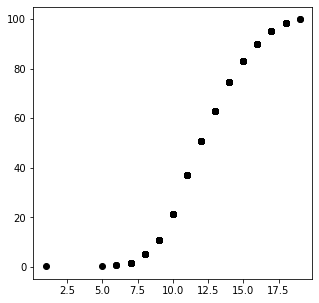

In [5]:
# grade percentiles
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
from scipy import stats
df['grade_percentile'] = df['G3'].apply(lambda x: stats.percentileofscore(df['G3'],x))
plt.figure(figsize=(5,5))
plt.scatter(df['G3'],df['grade_percentile'],c='k');

### GLM 

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

Quick recap on OLS or Gaussian GLM.
- Guassian GLm predicts mean value Y (Ymu) given constant scale.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      198
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.99136
Method:                          IRLS   Log-Likelihood:                -281.91
Date:                Mon, 08 Feb 2021   Deviance:                       196.29
Time:                        19:49:51   Pearson chi2:                     196.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7547      0.250     -3.021      0.0

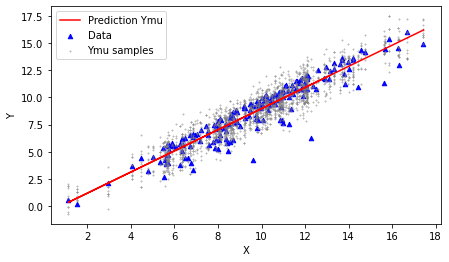

In [7]:
# recap on gaussian model
fig,axs = plt.subplots(1,1,figsize=(7,4))

# dummy data
n = 200
Xy = pd.DataFrame({'X':np.random.normal(loc=10,scale=3,size=n)})
Xy['y'] = Xy.X - np.random.gamma(shape=1,scale=1,size=n)

axs.scatter(Xy.X,Xy.y,c='blue',s=20,marker='^',label='Data')

# fit model
Xym = smf.glm(formula='y~X',data=Xy).fit()
print(Xym.summary())

# prediction : plot mean
Xy['P'] = Xym.predict()
axs.plot(Xy.X,Xy.P,c='red',label='Prediction Ymu')

# predictions : plot 10 samples of model mean with standard deviation
for r in range(10):
    a = np.random.normal(loc=Xy.P,scale=Xym.scale)
    axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5)
axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5,label='Ymu samples')
axs.set_xlabel('X')
axs.set_ylabel('Y')
    
axs.legend();

Other than age, most features in this dataset have been cut into categories. I could convert the values into objects so that our modelling packages identify and treat variables appropriately. Alternatively in statsmodels formula we can directly specify the categorical variables by "C(categorical_feature)".

In [8]:
# model grade data
formula = [f"{f}" if f not in categoricals else f"C({f})" for f in features]
formula = f'{target[0]} ~ ' + ' + '.join(formula)
glm = smf.glm(formula=formula,
              data=df,
              family=sm.families.Gaussian()).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     G3   No. Observations:                  634
Model:                            GLM   Df Residuals:                      615
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                          5.0961
Method:                          IRLS   Log-Likelihood:                -1406.2
Date:                Mon, 08 Feb 2021   Deviance:                       3134.1
Time:                        19:49:52   Pearson chi2:                 3.13e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.9220      1.890      2.604      0.009       1.217       8.627
C(internet)[T.yes]     0.3737      0.226      1.657      0.098      -0.068       0.816
C(failures)[T.1]      -2.3646      0.323     -7.327      0.000      -2.997      -1.732
C(failures)[T.2]      -2.7874      0.622     -4.481      0.000      -4.007      -1.568
C(failures)[T.3]      -3.0598      0.657     -4.655      0.000      -4.348      -1.771
C(higher)[T.yes]       1.7469      0.330      5.293      0.000       1.100       2.394
C(Medu)[T.1]          -0.1246      0.959     -0.130      0.897      -2.004       1.755
C(Medu)[T.2]           0.1676      0.962      0.174      0.862      -1.717       2.053
C(Medu)[T.3]           0.2000      0.973      0.206      0.837      -1.706       2.106
C(Medu)[T.4]           1.0028      0.981      1.022      0.307      -0.920       2.926
C(Fedu)[T.1]          -0.4706      0.891     -0.528      0.597      -2.217       1.276
C(Fedu)[T.2]          -0.1023      0.898     -0.114      0.909      -1.863       1.659
C(Fedu)[T.3]          -0.4071      0.914     -0.445      0.656      -2.199       1.385
C(Fedu)[T.4]          -0.1982      0.925     -0.214      0.830      -2.011       1.615
C(studytime)[T.2]      0.5495      0.214      2.573      0.010       0.131       0.968
C(studytime)[T.3]      1.0308      0.290      3.552      0.000       0.462       1.600
C(studytime)[T.4]      1.0475      0.421      2.488      0.013       0.222       1.873
age                    0.3272      0.081      4.026      0.000       0.168       0.486
absences              -0.0610      0.020     -3.007      0.003      -0.101      -0.021
======================================================================================
"""

In [9]:
from sklearn import metrics

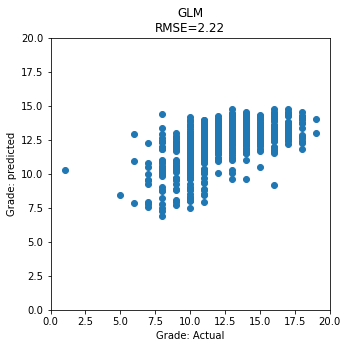

In [10]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

yhat = glm.predict(df)
rmse = np.sqrt(np.mean((yhat - df[target].values.reshape(-1,))**2))
rmse = metrics.mean_squared_error(df[target],yhat,squared=False)

axs.scatter(df[target],yhat)
axs.set_title(f'GLM\nRMSE={rmse:.2f}')
axs.set_xlabel('Grade: Actual')
axs.set_ylabel('Grade: predicted')
axs.set_xlim(0,20)
axs.set_ylim(0,20);

## PyMC3 GLM

Now lets re-build our GLM model using PyMC3.

In [11]:
import pymc3 as pm

In [12]:
# note we can re-use our formula 
formula

'G3 ~ C(internet) + C(failures) + C(higher) + C(Medu) + C(Fedu) + C(studytime) + age + absences'

In [13]:
with pm.Model() as normal_model:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    # create the model 
    pm.GLM.from_formula(formula,data=df,family=family)
    # sample
    trace = pm.sample(draws=1000,chains=3,tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sd, absences, age, C(studytime)[T.4], C(studytime)[T.3], C(studytime)[T.2], C(Fedu)[T.4], C(Fedu)[T.3], C(Fedu)[T.2], C(Fedu)[T.1], C(Medu)[T.4], C(Medu)[T.3], C(Medu)[T.2], C(Medu)[T.1], C(higher)[T.yes], C(failures)[T.3], C(failures)[T.2], C(failures)[T.1], C(internet)[T.yes], Intercept]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [03:53<00:00, 19.23draws/s]


Once the model has run we can examine the model posterior distribution samples. This is akin to viewing the ```model.summary()``` of a classic linear model. Here the mean is the estimate of the feature distribution. In our case the model intercept mean is around 4.9, meaning a student is expected to attain at least a grade of 4.9 irrespective of what we know about them. 

The 3-97% highest posterior density "hpd" range indicates the credible interval for the true value of our parameter. As for classical models if this range crosses 0, from negative effect to positive effect, then perhaps the data signal is too weak to draw conclusions for this variable. This is the case for Internet usage - darnit Covid19. 

In [14]:
summary = pm.summary(trace)
summary[:5]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,4.916,1.894,1.432,8.480,0.050,0.036,1416.0,1416.0,1419.0,1950.0,1.0
C(internet)[T.yes],0.369,0.227,-0.073,0.768,0.003,0.003,4321.0,2955.0,4330.0,2091.0,1.0
C(failures)[T.1],-2.367,0.323,-2.953,-1.769,0.006,0.004,3023.0,3023.0,3015.0,2028.0,1.0
C(failures)[T.2],-2.778,0.608,-4.038,-1.781,0.011,0.008,3153.0,3059.0,3148.0,2047.0,1.0
C(failures)[T.3],-3.056,0.652,-4.195,-1.780,0.012,0.008,3116.0,3116.0,3118.0,2175.0,1.0


The posterior distributions can also be viewed via traceplots. 

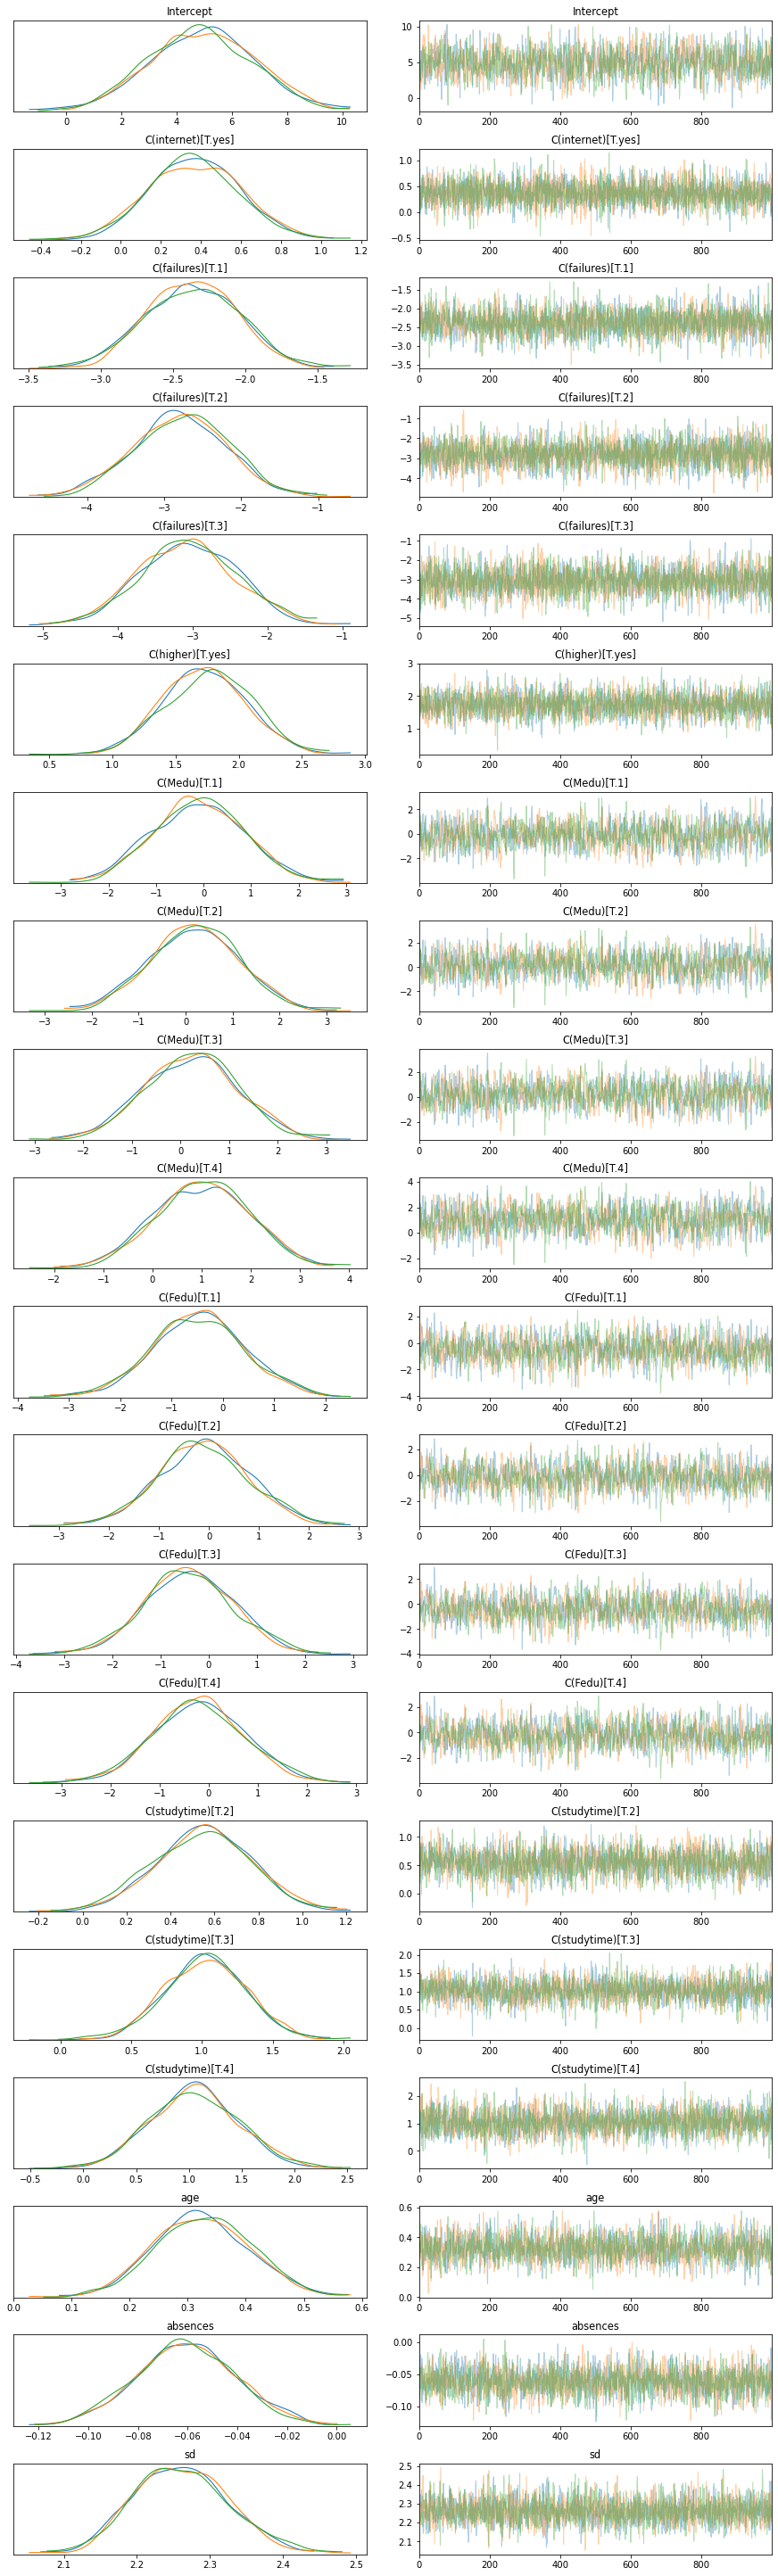

In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pm.traceplot(trace)
    
# alternatively via the posterior plot function
# pm.plot_posterior(trace);

In [20]:
# pm.plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")

## references
- [Getting started with GLM in PyMC3](https://docs.pymc.io/notebooks/getting_started.html?highlight=glm)
- [robust GLM's in PyMC3](https://docs.pymc.io/notebooks/GLM-robust.html)